In [28]:
# ===========================================
# 1. Preparación de datos con indicadores
# ===========================================
import numpy as np
import pandas as pd
import os

# Cargar datos
df = pd.read_csv(os.path.join('HSM','stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume', 'OpenInt'])

# Ordenar por fecha
df = df.sort_values("Date").reset_index(drop=True)

# Retorno en 90 días
df["return_90"] = df["Close"].shift(-90) / df["Close"] - 1

# Target multiclase con umbral ±8%
df["target"] = 1  # Hold por defecto
df.loc[df["return_90"] > 0.08, "target"] = 2  # Buy
df.loc[df["return_90"] < -0.08, "target"] = 0  # Sell

df = df.dropna().reset_index(drop=True)

# ===========================
# 2. Features (OHLCV + indicadores)
# ===========================
df["return_1"] = df["Close"].pct_change()
df["volatility"] = df["High"] - df["Low"]
df["sma_5"] = df["Close"].rolling(5).mean()
df["sma_20"] = df["Close"].rolling(20).mean()
df["ema_10"] = df["Close"].ewm(span=10, adjust=False).mean()

# RSI
delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["rsi"] = 100 - (100 / (1 + rs))

# MACD
ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
df["macd"] = ema_12 - ema_26

df = df.dropna().reset_index(drop=True)

FEATURES = ["Open", "High", "Low", "Close", "Volume", 
            "return_1", "volatility", "sma_5", "sma_20", 
            "ema_10", "rsi", "macd"]

X = df[FEATURES].values
y = df["target"].values

# ===========================
# 3. Split temporal
# ===========================
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [30]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Distribución original:", np.bincount(y_train))
print("Distribución balanceada:", np.bincount(y_train_res))

Distribución original: [2522 2790 4260]
Distribución balanceada: [4260 4260 4260]


c:\Users\Alejandro\Documents\GitHub\ML-StockMarket\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:03:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost (90d ±8% con oversampling) ===
              precision    recall  f1-score   support

        Sell       0.27      0.11      0.16       825
        Hold       0.25      0.25      0.25       658
         Buy       0.36      0.55      0.44       911

    accuracy                           0.32      2394
   macro avg       0.29      0.30      0.28      2394
weighted avg       0.30      0.32      0.29      2394



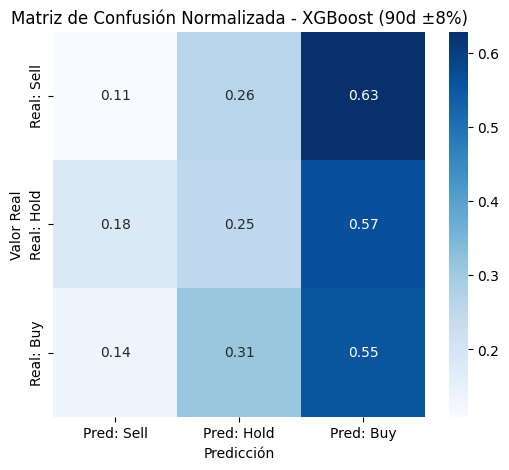

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgb = XGBClassifier(
    objective="multi:softmax", num_class=3,
    eval_metric="mlogloss", use_label_encoder=False,
    n_estimators=300, max_depth=6, learning_rate=0.05
)

xgb.fit(X_train_res, y_train_res)  # 👈 entrenamos con oversampling

y_pred_xgb = xgb.predict(X_test)

print("=== XGBoost (90d ±8% con oversampling) ===")
print(classification_report(y_test, y_pred_xgb, target_names=["Sell","Hold","Buy"]))

cm = confusion_matrix(y_test, y_pred_xgb)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Pred: Sell","Pred: Hold","Pred: Buy"],
            yticklabels=["Real: Sell","Real: Hold","Real: Buy"])
plt.title("Matriz de Confusión Normalizada - XGBoost (90d ±8%)")
plt.ylabel("Valor Real")
plt.xlabel("Predicción")
plt.show()


Epoch 1/40
400/400 - 20s - 49ms/step - accuracy: 0.3516 - loss: 1.0893 - val_accuracy: 0.4312 - val_loss: 1.0876
Epoch 2/40
400/400 - 17s - 43ms/step - accuracy: 0.3585 - loss: 1.0832 - val_accuracy: 0.4761 - val_loss: 1.0830
Epoch 3/40
400/400 - 18s - 45ms/step - accuracy: 0.3613 - loss: 1.0783 - val_accuracy: 0.3921 - val_loss: 1.0912
Epoch 4/40
400/400 - 16s - 39ms/step - accuracy: 0.3663 - loss: 1.0773 - val_accuracy: 0.4270 - val_loss: 1.0903
Epoch 5/40
400/400 - 17s - 42ms/step - accuracy: 0.3674 - loss: 1.0752 - val_accuracy: 0.4034 - val_loss: 1.0973
Epoch 6/40
400/400 - 16s - 41ms/step - accuracy: 0.3727 - loss: 1.0733 - val_accuracy: 0.3350 - val_loss: 1.0876
Epoch 7/40
400/400 - 16s - 41ms/step - accuracy: 0.3785 - loss: 1.0711 - val_accuracy: 0.3329 - val_loss: 1.0917
Epoch 8/40
400/400 - 17s - 42ms/step - accuracy: 0.3824 - loss: 1.0699 - val_accuracy: 0.3875 - val_loss: 1.0786
Epoch 9/40
400/400 - 17s - 43ms/step - accuracy: 0.3860 - loss: 1.0670 - val_accuracy: 0.3136 - 

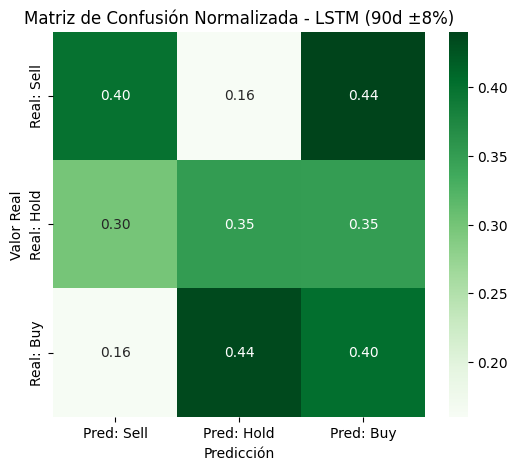

In [33]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models

# Escalado
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Secuencias
def create_sequences(X, y, window=60):
    xs, ys = [], []
    for i in range(len(X)-window):
        xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(xs), np.array(ys)

WINDOW = 60
X_seq, y_seq = create_sequences(X_scaled, y, WINDOW)

split = int(len(X_seq)*0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Oversampling en secuencias
X_flat = X_train.reshape(len(X_train), -1)
ros = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = ros.fit_resample(X_flat, y_train)
X_train_res = X_res.reshape(-1, WINDOW, X_seq.shape[2])

# One-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_res, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Modelo LSTM
tf.random.set_seed(42)
model = models.Sequential([
    layers.Input(shape=(WINDOW, X_seq.shape[2])),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train_res, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=40,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
    verbose=2
)

y_pred_probs = model.predict(X_test)
y_pred_lstm = np.argmax(y_pred_probs, axis=1)

print("=== LSTM (90d ±8% con oversampling) ===")
print(classification_report(y_test, y_pred_lstm, target_names=["Sell","Hold","Buy"]))

cm = confusion_matrix(y_test, y_pred_lstm)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=["Pred: Sell","Pred: Hold","Pred: Buy"],
            yticklabels=["Real: Sell","Real: Hold","Real: Buy"])
plt.title("Matriz de Confusión Normalizada - LSTM (90d ±8%)")
plt.ylabel("Valor Real")
plt.xlabel("Predicción")
plt.show()
